In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
data = pd.read_feather("dataFrame.feather")
data["category"] = pd.Categorical(data["category"])
print(data.shape)
X = data["text"]
Y = pd.get_dummies(data["category"])
train_X, test_X, train_Y, test_Y = train_test_split(X, Y, test_size = 0.2)

(2225, 3)


In [2]:
# that would be great but you dont have enough memory
import gensim

# Load Google's pre-trained Word2Vec model.
#model = gensim.models.KeyedVectors.load_word2vec_format('/home/robertb/Desktop/text_embeddings/project/GoogleNews-vectors-negative300.bin', binary=True)  
model_w2v = gensim.models.Word2Vec.load('/home/robertb/Desktop/text_embeddings/project/simple_word2vec.model')  

# get word embedding matrix
embedding_layer = model_w2v.wv.get_keras_embedding(train_embeddings=True)


Using TensorFlow backend.


In [2]:
# Only if pretrained model is not available


# learn embedings
# import gensim 
# from nltk.tokenize import sent_tokenize, word_tokenize

# text_new_line = [data.iloc[i,1].replace('\n', ". ") for i in range(data.shape[0])]
# text_tokenized = [word_tokenize(text_new_line[i]) for i in range(len(text_new_line))]

# model = gensim.models.Word2Vec(
#         text_tokenized,
#         size=100,
#         window=6,
#         min_count=1,
#         workers=4,
#         iter=10)

# model.save("simple_word2vec.model")


In [3]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
# get pairs word:index(word) 
vocabulary = {token: token_index for token_index, token in enumerate(model_w2v.wv.index2word)} 
# change words to integer seq using indexes
tk = Tokenizer(num_words=len(vocabulary)) 
tk.word_index = vocabulary 

train_text_seq = tk.texts_to_sequences(train_X)
maxlen = max([len(text) for text in train_text_seq])
train_text_seq = pad_sequences(train_text_seq, maxlen=maxlen, padding="post", value=0.0)

test_text_seq = tk.texts_to_sequences(test_X)
test_text_seq = pad_sequences(test_text_seq, maxlen=maxlen, padding="post", value=0.0)



In [4]:
import keras.models as km
from keras.layers import Activation, Dense, Embedding, Bidirectional, Dropout, LSTM
# define the model
model_NN = km.Sequential()

#model_NN.add(Embedding(len(vocabulary)+1,100,trainable=True))
model_NN.add(embedding_layer)

model_NN.add(Bidirectional(LSTM(16, return_sequences=False)))

model_NN.add(Dense(5, activation='softmax'))
# compile the model
model_NN.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
# summarize the model
print(model_NN.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 100)         4226700   
_________________________________________________________________
bidirectional_1 (Bidirection (None, 32)                14976     
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 165       
Total params: 4,241,841
Trainable params: 4,241,841
Non-trainable params: 0
_________________________________________________________________
None


In [5]:
hist=model_NN.fit(train_text_seq,
                  train_Y,
                  epochs=5,
                  batch_size=128,
                  validation_data=(test_text_seq, test_Y),
                  verbose=1)

/home/robertb/anaconda3/lib/python3.6/site-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 1780 samples, validate on 445 samples
Epoch 1/5
1780/1780 [==============================] - 142s 80ms/step - loss: 1.5980 - accuracy: 0.2624 - val_loss: 1.5387 - val_accuracy: 0.3371
Epoch 2/5
1780/1780 [==============================] - 133s 75ms/step - loss: 1.4972 - accuracy: 0.4000 - val_loss: 1.4425 - val_accuracy: 0.4427
Epoch 3/5
1780/1780 [==============================] - 139s 78ms/step - loss: 1.3746 - accuracy: 0.5242 - val_loss: 1.3115 - val_accuracy: 0.5618
Epoch 4/5
1780/1780 [==============================] - 158s 89ms/step - loss: 1.2153 - accuracy: 0.6253 - val_loss: 1.1349 - val_accuracy: 0.6539
Epoch 5/5
1780/1780 [==============================] - 139s 78ms/step - loss: 1.0246 - accuracy: 0.7039 - val_loss: 0.9512 - val_accuracy: 0.7056


   val_loss  val_accuracy      loss  accuracy
0  1.538684      0.337079  1.598016  0.262360
1  1.442531      0.442697  1.497157  0.400000
2  1.311496      0.561798  1.374581  0.524157
3  1.134909      0.653933  1.215316  0.625281
4  0.951231      0.705618  1.024592  0.703933


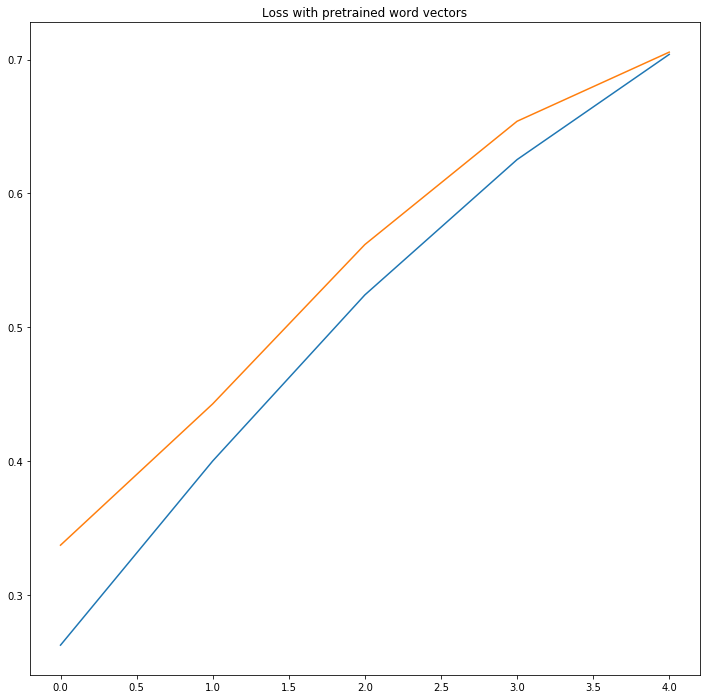

In [11]:
import matplotlib.pyplot as plt
print(history)
history = pd.DataFrame(hist.history)
plt.figure(figsize=(12,12));
plt.plot(history["accuracy"]);
plt.plot(history["val_accuracy"]);
plt.title("Loss with pretrained word vectors");
plt.show();